# Project onto Nestorowa Landscape
## Xiaonan Wang
## 07Jan2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [2]:
adata = sc.read('./write/Ageing_norm.h5ad')
adata = anndata.AnnData(X=np.exp(adata.X.toarray())-1, obs=adata.obs, var=adata.var, obsm=adata.obsm)

In [3]:
ref_data = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Nestorowa_data/Nestorowa_processed.h5ad')

ref_hvg = ref_data.var_names[ref_data.var['HVG']]
print(len(ref_hvg))

ref_data = anndata.AnnData(X=np.exp(ref_data.raw.X)-1, obs=ref_data.obs, var=ref_data.raw.var, obsm=ref_data.obsm, uns=ref_data.uns)

4448


In [4]:
OLG = np.intersect1d(ref_hvg, adata.var_names)
print(len(OLG))
adata = adata[:,OLG].copy()
ref_data = ref_data[:,OLG].copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(ref_data, counts_per_cell_after=10000)

sc.pp.log1p(adata)
sc.pp.log1p(ref_data)

4366
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [5]:
sc.pp.scale(adata)
sc.pp.scale(ref_data)

In [6]:
print(adata.shape)
print(ref_data.shape)

(21708, 4366)
(1645, 4366)


In [7]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [8]:
pca_.fit(ref_data.X)

PCA(n_components=50, random_state=0)

In [9]:
X_pca1 = pca_.transform(ref_data.X)
X_pca2 = pca_.transform(adata.X)

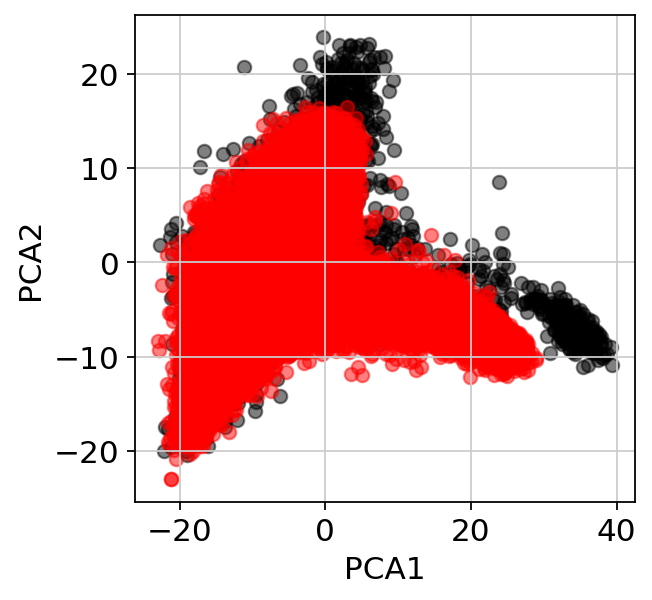

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [11]:
from sklearn.metrics.pairwise import euclidean_distances
D_sub = euclidean_distances(X_pca2, X_pca1)

In [12]:
from collections import defaultdict
cl_assigned = []
Rstore = defaultdict(list) # dictionary to store results
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    cl_assigned.append(np.in1d(range(len(CellDis)), CellDis_sorted))
    Rstore['MinDist'].append(np.min(CellDis[CellDis_sorted]))
    Rstore['MedianDist'].append(np.median(CellDis[CellDis_sorted]))
    Rstore['MaxDist'].append(np.max(CellDis[CellDis_sorted]))
    Rstore['SD'].append(np.std(CellDis[CellDis_sorted]))
    Rstore['Nestorowa_CT'].append(ref_data[CellDis_sorted,:].obs['new_CT'].value_counts().index[0])
Rstore = pd.DataFrame.from_dict(Rstore)
Rstore.index = adata.obs_names

In [13]:
Rstore.to_csv('Proj_results_nestorowa.csv')

In [14]:
cl_assigned = np.vstack(cl_assigned)
print(cl_assigned.shape)

(21708, 1645)


In [15]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    print(CT)
    for ct in CT:
        idx = proj_data.obs[proj_data_obs] == ct
        ca_new = cl_assigned[idx,:]
        ref_data.obs[prefix+'_'+ct] = np.log2(np.sum(ca_new, axis=0)+1)

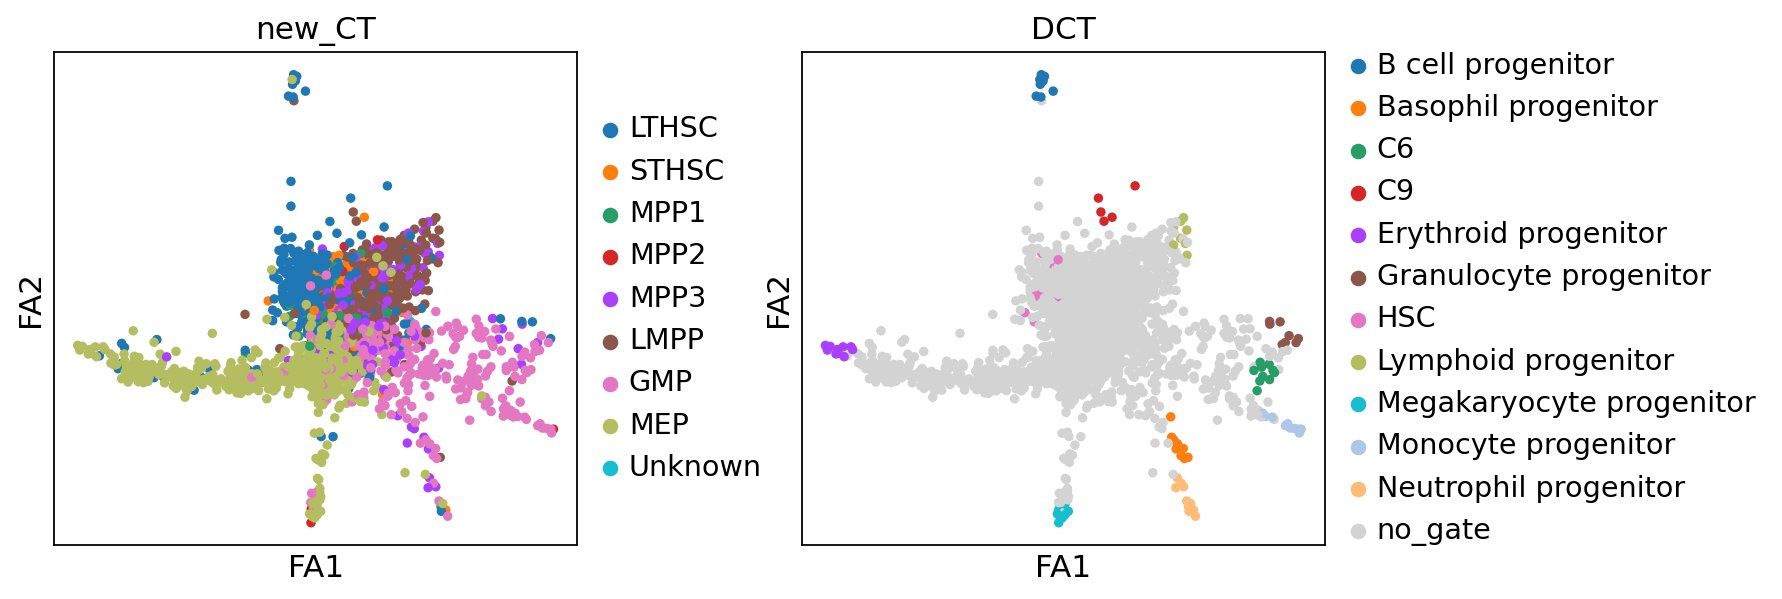

In [16]:
sc.pl.draw_graph(ref_data, color=['new_CT', 'DCT'], legend_loc="right margin", color_map=cmap, wspace=.3)

In [17]:
Obs_sublabels(ref_data, adata, 'Age', cl_assigned, 'SubCon')

['16-week' '68-week' '88-week']


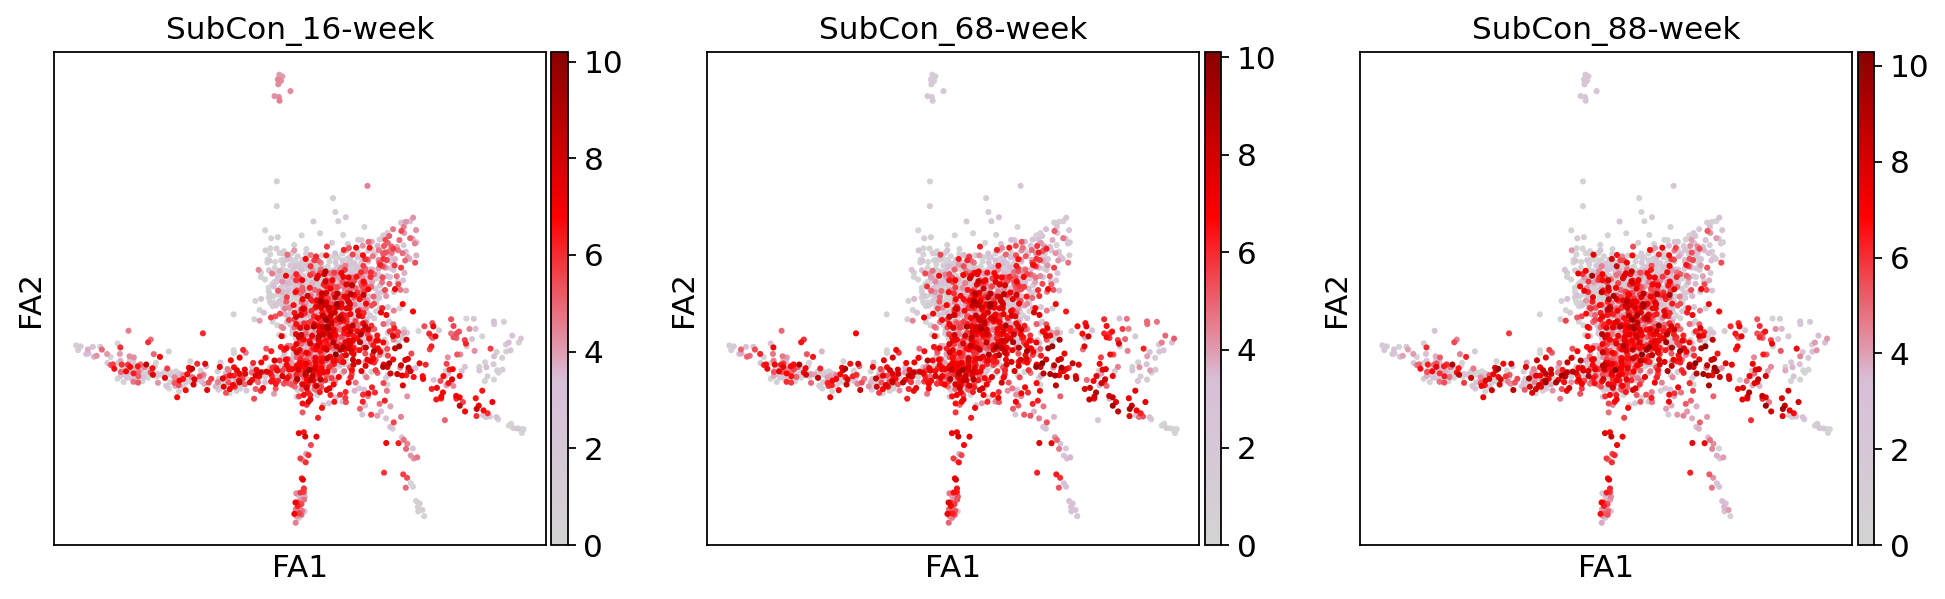

In [19]:
sc.pl.draw_graph(ref_data, color=['SubCon_'+x for x in adata.obs['Age'].cat.categories], legend_loc="right margin", color_map=cmap, size=30)